Update: Prefer to find a day during Finals Week (rather than during the last week of semester). But When2Meet doesn't allow scheduling this far in advance!
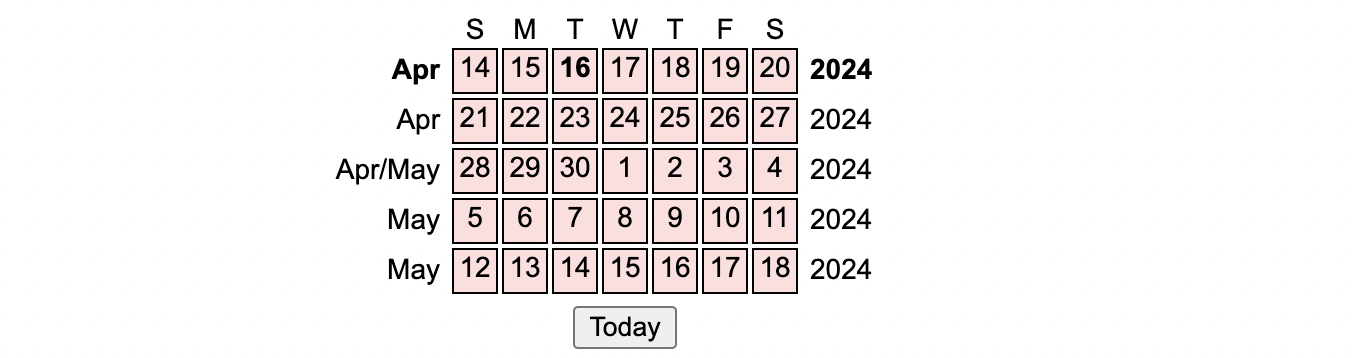

I'll send something out next week.

# Goals

We are going to build a simple CB-IAM, based on the SC-IAM we built in Lab 3.

To do that, we need:
 - A model of emissions
 - Estimates of mitigation costs
 - An optimization step

# Get a new dataset

The dataset comes from the ENGAGE project, an intermodel comparison of DP-IAMs:
https://data.ene.iiasa.ac.at/engage/#/downloads

The full dataset is 95 MB and includes 9 PB-IAMs and 182 scenarios:
https://www.dropbox.com/s/u3drzbpl91r331z/ENGAGE_scenario_data_world_r2.0.csv?dl=0

We are going to use two versions of this data: for baseline characteristics, we will use the "no policy" scenario of one DP-IAM called AIM/CGE which includes a computational general equilibrium model and a sophisticated energy system. For modeling mitigation, we will use all models and scenarios, but only a few output variables.

Download the first file from
https://www.dropbox.com/scl/fi/04y9nuz7jydwq8tbv9080/aimcge-np.csv?rlkey=wy965td792moq76kl1zr178u1&dl=0

In [ ]:
input = read.csv(...)

In [ ]:
library(reshape2)

In [ ]:
input2 = melt(input, c('Model', 'Scenario', 'Region', 'Variable', 'Unit'))

In [ ]:
input2 = subset(input2, !is.na(value))

In [ ]:
input2$year = as.numeric(substring(input2$variable, 2, 5))

In [ ]:
temp = subset(input2, Variable == 'Diagnostics|MAGICC6|Temperature|Global Mean')

In [ ]:
plot(temp$year, temp$value, type='l')

In [ ]:
library(ggplot2)
ggplot(input2[grep("Primary Energy\\|", input2$Variable),], aes(year, value, fill=Variable)) + geom_col()

In [ ]:
ggplot(input2[grep("Primary Energy\\|[^|]+$", input2$Variable),], aes(year, value, fill=Variable)) + geom_col()

In [ ]:
ggplot(input2[grep("Final Energy\\|[^|]+$", input2$Variable),], aes(year, value, fill=Variable)) + geom_col()

In [ ]:
ggplot(input2[grep("Final Energy\\|Transportation\\|[^|]+$", input2$Variable),], aes(year, value, fill=Variable)) + geom_col()

# A common baseline

Let's get a common version of our final model from Lab 3, modified to use this new data.

In [ ]:
## Parameters
RR = 3.8 # Forcing at 2x CO2
C0 = 280 # Pre-industrial CO2
c = 0.098 # reaction rate of atmosphere
ECS = 3 # Equilibrium climate sensitivity
alpha = 1.0038 # Damage function scale
c.1960 = 3585.427 # GDP p.c. in 1960
c.2020 = 10542.301 # GDP p.c. in 2020
eta = 1.45 # Elasticity of marginal consumption

## Load the CO2 concentrations
co2 = read.csv("...")
## Select the SSP2-4.5 scenario for concentrations after 1960
co2.ssp245 = subset(co2, scenario == 'ssp245' & year > 1960)

## Set up the initial values: T_1960 = 0.2 C.
df = data.frame(year=1960, T=0.2, D=NA, cbar=NA, u=NA)
## Loop over all years from 1960 to 2300
for (tt in 1961:2300) {
  ## Retrieve the CO2 concentration in year tt
  C1 = co2.ssp245$value[co2.ssp245$year == tt]
  ## Calculate the radiative foring
  F = (RR / log(2)) * log(C1 / C0)
  ## Update the warming level, using the last row of df for the previous year
  T = df$T[nrow(df)] + c * (F - (RR / ECS) * df$T[nrow(df)])
  ## Compute the damages
  D = alpha * T^2
  ## Compute social welfare
  cbar = (c.2020 - c.1960) * (tt - 1960) / (2020 - 1960) + c.1960
  cc = cbar * (1 - D / 100)
  uu = (cc^(1 - eta)) / (1 - eta)
  ## Add on the results for the new year to df
  df = rbind(df, data.frame(year=tt, T=T, D=D, cbar, u=uu))
}

 - Find the CO2 concentration variable in our baseline dataset.
 - Incorporate that into the loop.
 - What does the resulting temperature look like?

# Kaya identity emissions

We are going to use our simplified model of emissions, the Kaya identity.

 - Collect the Population, GDP, Primary Energy, and CO2 Emissions variables
 - Construct energy intensity and emissions intensity
 - Show that we can recover total CO2 emissions from Kaya product

Simplify this to carbon-intensity of GDP (rather than of energy).

 - Instead, construct emissions intensity of GDP
 - Show that this gives us the same result

We need annual values. Let's interpolate!

In [ ]:
future = data.frame(year=2010:2100, pop=approx(emits$year, pop$value, 2010:2100)$y,
                    gdppc=approx(gdp$year, gdp$gdppc, 2010:2100)$y,
                    cigdp=approx(emits$year, emits$cigdp, 2010:2100)$y)

We can use a simple OLS model to find the conversion from emissions to ppm.

$$ppm_t = \alpha + \beta \sum_{s \le t} emit_t + \epsilon_t$$

In [ ]:
yy = co2$value[co2$year >= 2010 & co2$year <= 2100]
xx = cumsum(future$pop * future$gdppc * future$cigdp)

In [ ]:
plot(xx, yy)

In [ ]:
summary(lm(yy ~ xx))

 - Incorporate this into the code
 - What does the temperature trajectory look like now?
 - What happens if I stop emissions today?

# Mitigation costs

We need an estimate of global mitigation costs. For this, we will use our second file. Download it from here:
https://www.dropbox.com/scl/fi/xxdltbl9diuqa0hylgy6d/allmodels3-long.csv?rlkey=wt5o39nl2pzw4v0pb9kn6cc06&dl=0

In [ ]:
mitdf = read.csv("~/Dropbox/Climate Change Economics 2024/labs/lab5 - integrated assessment/allmodels3-long.csv")

Let's use regression to infer how carbon price reduces emissions and also reduces consumption.

We assume that every model and scenario has a different underlying growth rate of emissions and consumption.

In [ ]:
# Construct a name for each baseline
mitdf$run = paste(mitdf$Model, mitdf$Scenario)

In [ ]:
summary(lm(log(Consumption) ~ factor(Year) + run + log(Price.Carbon), data=subset(mitdf, Price.Carbon > 0)))

In [ ]:
logp2logcons = ???

In [ ]:
summary(lm(log(Emissions.CO2) ~ factor(Year) + run + log(Consumption) + Price.Carbon, data=mitdf))

In [ ]:
p2logemit = ???

 - Define a reduction path as a linear growth of carbon price.

In [ ]:
policy = data.frame(tt=2010:2100)
policy$price = ???

In [ ]:
plot(policy$tt, policy$price)

In [ ]:
policy$emitred = exp(p2logemit * policy$price)
policy$consloss = exp(logp2logcons * log(policy$price))

 - Multiply Kaya identity values by emissions reduction.

Now add on abatement costs.

 - Calculate consumption reduction
 - Calculate total consumption as baseline * (1 - damage) * consuption reduction

Now we want to optimize this, as a function of the rate of carbon price increase.

In [ ]:
simulate = function(rate) {
    [Your whole loop.]
    
    df
}

In [ ]:
df = simulate(1)

In [ ]:
plot(df$year, df$consleft)

In [ ]:
df1 = simulate(1)
df2 = simulate(10)

In [ ]:
plot(df1$year, df1$u)
lines(df2$year, df2$u)

In [ ]:
plot(df1$year, df1$D + 100 * (1 - df1$consleft))
lines(df2$year, df2$D + 100 * (1 - df2$consleft))

Now let's construct the net present value of utility.

In [ ]:
rho = 1.5 / 100
year0 = 2020

npv = function(rate) {
    df = simulate(rate)
    
    ???
}

In [ ]:
plot(1:100, sapply(1:100, npv))

In [ ]:
optimize(npv, c(0, 50), maximum=TRUE)

In [ ]:
df = simulate(???)

In [ ]:
plot(df$year, df$T)

In [ ]:
plot(df$year, df$consleft)

In [ ]:
plot(df$year, df$D)